# Data Wrangling |  Modeling Spotify track popularity
## Leo Evancie, Springboard Data Science Career Track

This is the first step in a capstone project to model music popularity on Spotify, a popular streaming service. Further project details and rationale can be found in the document 'Proposal.pdf'.

Note: This notebook makes use of <i>Spotipy</i>, a Python library designed for Spotify API calls. I referred to the Medium article "<a href="https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b">Getting Started with Spotify's API & Spotipy</a>" by Max Tingle (2019), as well as the <a href="https://spotipy.readthedocs.io/en/latest/#"><i>Spotipy</i> documentation.</a>

## Table of Contents:

* [1. Data Collection](#data-collection)
* [2. Data Organization](#data-organization)
* [3. Data Definition](#data-definition)
* [4. Data Cleaning](#data-cleaning)

## 1. Data Collection <a class="anchor" id="data-collection"></a>

First, I import the relevant libraries:

In [217]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv

I load my Spotify developer credentials from evironmental variables and instantiate the Spotify API client.

In [2]:
load_dotenv()
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### Exploratory dataset generation

I retrieve a sampling of 20 albums (the default response limit) from the year 2021 to get a sense of the response structure.

In [3]:
album_results = sp.search(q='year:2021', type='album')

In [4]:
type(album_results)

dict

In [5]:
album_results['albums']['items'][0].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

I notice that `popularity` is not listed among the returned data. This is the variable I want my model to predict. Let's try a search for individual tracks instead.

In [6]:
track_results = sp.search(q='year:2021', type='track')
track_results = track_results['tracks']['items']
track_results[0].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

I see that I will need to search for a large quantity of tracks, rather than albums, in order to develop a model for predicting `popularity`. As such, I can expect that `album` and `artists` will heavily influence `popularity`. Hopefully, I can identify plenty of other influential features. After all, an artist can't change their identity in the hope of boosting their music's popularity score.

I'll look at the sample results in a DataFrame to get a clearer picture of the values. I will choose only those variables that seem relevant to the question at hand. For example, I will exclude `preview_url`, and other references, keeping `track_id` as a unique identifier.

In [7]:
track_id = []
name = []
artist_name = []
popularity = []
duration_ms = []
explicit = []
track_number = []
available_markets = []
disc_number = []
album_type = []

for track in track_results:
    track_id.append(track['id'])
    name.append(track['name'])
    artist_name.append(track['artists'][0]['name'])
    popularity.append(track['popularity'])
    duration_ms.append(track['duration_ms'])
    explicit.append(track['explicit'])
    track_number.append(track['track_number'])
    available_markets.append(track['available_markets'])
    disc_number.append(track['disc_number'])
    album_type.append(track['album']['album_type'])
    
track_df = pd.DataFrame({
    'track_id':track_id,
    'name':name,
    'artist_name':artist_name,
    'popularity':popularity,
    'duration_ms':duration_ms,
    'explicit':explicit,
    'track_number':track_number,
    'disc_number':disc_number,
    'available_markets':available_markets,
    'album_type':album_type
})

track_df

,track_id,name,artist_name,popularity,duration_ms,explicit,track_number,disc_number,available_markets,album_type
0,748mdHapucXQri7IAO8yFK,Kiss Me More (feat. SZA),Doja Cat,99,208866,True,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
1,08ejYlzduA6O82FJgnFKQz,Year 2020,Leonardo Makno,34,133281,False,2,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
2,0UsmyJDsst2xhX1ZiFF3JW,"Year,2015",Schoolgirl Byebye,25,74301,False,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
3,7hCUv1ll5KnIsC86qPEHKK,King,Years & Years,1,214834,False,31,1,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, B...",compilation
4,43PGPuHIlVOc04jrZVh9L6,RAPSTAR,Polo G,94,165925,True,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
5,0yY6G6gbjJMJPCqDViMD1Q,RAGGG FOUND YEAR (2021),BIG BLU RAGGG,0,191721,True,13,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album
6,7BFk1nSfwfkDOgnNNeY7Yn,wish i dropped out like brakence interlude,Satoshi Love,0,83000,False,4,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album
7,0Blc7XVTogOjHlNKAa1Y7T,Eyes Shut,Years & Years,2,198226,False,17,1,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, B...",compilation
8,5CZ40GBx1sQ9agT82CLQCT,traitor,Olivia Rodrigo,95,229226,False,2,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album
9,6vGpoXiW800aaQCjjZHrOZ,Eterno Viajero - Live Streaming New Year 2021 ...,Amaranta,6,324903,False,12,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album


A few questions occur to me at this stage. What is to be made of the `available_markets` field? Are most songs available in the same large set of markets, or perhaps one of a few groups of markets, or is there greater variation?

Also, I see that the first track contains a feature, as shown in the track name: "Kiss Me More (feat. SZA)." Later, I could use a bit of string analysis to create a new Boolean field, `collaboration`, in case the presence of a featured artist has some bearing on popularity.

Perhaps most importantly, some tracks have a `popularity` score of zero. What accounts for zero popularity? Is it a missing value, or due to being quite new on the platform? Do some tracks genuinely enjoy zero popularity among listeners even after several months, or years? I will need to do some thinking about how to handle such scores in my analysis.

### Retrieving quantitative variables: Audio features

Meanwhile, I do not have enough quantitative variables to build an effective model. Luckily, Spotify also offers an API endpoint for audio features, including quantities like `danceability` and `tempo`. Let's look at a sample response from such a search. I'll use a `track_id` from the above DataFrame.

In [8]:
sample_audio_feature = sp.audio_features(track_df['track_id'][0])
sample_audio_feature

[{'danceability': 0.762,
  'energy': 0.701,
  'key': 8,
  'loudness': -3.541,
  'mode': 1,
  'speechiness': 0.0286,
  'acousticness': 0.235,
  'instrumentalness': 0.000158,
  'liveness': 0.123,
  'valence': 0.742,
  'tempo': 110.968,
  'type': 'audio_features',
  'id': '748mdHapucXQri7IAO8yFK',
  'uri': 'spotify:track:748mdHapucXQri7IAO8yFK',
  'track_href': 'https://api.spotify.com/v1/tracks/748mdHapucXQri7IAO8yFK',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/748mdHapucXQri7IAO8yFK',
  'duration_ms': 208867,
  'time_signature': 4}]

### Full dataset generation

Now that I know how to retrieve all the fields I want, as well as how to convert my search results into a DataFrame, I will generate my full dataset. Spotify's search API allows for a maximum offset of 1,000 for their API search calls, with a maximum 50 records per call. I probably need about ten times that number of tracks for my model. I will thus execute the search 10 times, each for a different year. (This will introduce the possibility that the release year itself might affect popularity; maybe audiences respond to different aspects of music in different eras.) After retrieving each batch of 50 tracks, I will feed those into the audio features search, storing all relevant results as I go.

Note: In the early stages of developing this notebook, I had recorded the `year` of a given track based on the year supplied as the search parameter. However, I learned that not all tracks returned by the search "year:2012," for example, were actually released in 2012. Unfortunately, the Search API does not supply release date information. As such, along with adding the audio features search within each iteration of 50 search results, I will add a multi-track search (a separate API endpoint) specifically to retrieve the true release date from Spotify. This is the <i>album release year</i>. In the case of standalone tracks that do not belong to an album, the album release year is, in effect, the same as the track release year. In other cases, singles are released during one calendar year, and the full album is subsequently released the following year. In these latter cases, Spotify would list the later year (i.e., the album release year) as that single's release year. Spotify does not supply single release years to resolve such discrepancies. Ultimately, I view this potential for ever-so-slight inaccuracies as a fair tradeoff for the dramatically increased validity of pulling official dates from the source.

In [94]:
#initializing empty lists, which will become DataFrame columns
track_id = []
name = []
artist = []
album = []
year = []
popularity = []
duration_ms = []
explicit = []
track_number = []
available_markets = []
disc_number = []
album_type = []
danceability = []
energy = []
loudness = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
time_signature = []
mode = []
key = []

#looping through the years 2012 through 2021:
for yr in range(2012,2022):
    #due to search API constraints, searching for chunks of 50 tracks up to 1000 total for the given year:
    for i in range(0,1000,50):
        track_results = sp.search(q='year:{}'.format(yr), type='track', limit=50, offset=i)
        track_results = track_results['tracks']['items']
        #initialize a list to collect these 50 track IDs, to be used in subsequent audio feature & year searches
        track_ids = []
        #appending track info to lists
        for track in track_results:
            track_id.append(track['id'])
            name.append(track['name'])
            artist.append(track['artists'][0]['name'])
            album.append(track['album']['name'])
            popularity.append(track['popularity'])
            duration_ms.append(track['duration_ms'])
            explicit.append(track['explicit'])
            track_number.append(track['track_number'])
            available_markets.append(track['available_markets'])
            disc_number.append(track['disc_number'])
            album_type.append(track['album']['album_type'])
            track_ids.append(track['id'])
        #searching for corresponding audio features based on the track IDs from the search above
        feature_results = sp.audio_features(track_ids)
        for feature in feature_results:
            #while debugging, I found that a few tracks do not have audio feature data available
            if feature == None:
                danceability.append(np.nan)
                energy.append(np.nan)
                loudness.append(np.nan)
                speechiness.append(np.nan)
                acousticness.append(np.nan)
                instrumentalness.append(np.nan)
                liveness.append(np.nan)
                valence.append(np.nan)
                tempo.append(np.nan)
                time_signature.append(np.nan)
                mode.append(np.nan)
                key.append(np.nan)
            else:
                danceability.append(feature['danceability'])
                energy.append(feature['energy'])
                loudness.append(feature['loudness'])
                speechiness.append(feature['speechiness'])
                acousticness.append(feature['acousticness'])
                instrumentalness.append(feature['instrumentalness'])
                liveness.append(feature['liveness'])
                valence.append(feature['valence'])
                tempo.append(feature['tempo'])
                time_signature.append(feature['time_signature'])
                mode.append(feature['mode'])
                key.append(feature['key'])
        #retrieving release year, slicing first 4 characters due to varied date precision
        track_results_with_year = sp.tracks(track_ids)
        for track in track_results_with_year['tracks']:
            year.append(track['album']['release_date'][:4])
            
#constructing DataFrame from the now-complete lists
df = pd.DataFrame({
    'track_id':track_id,
    'name':name,
    'artist':artist,
    'album':album,
    'year':year,
    'popularity':popularity,
    'duration_ms':duration_ms,
    'explicit':explicit,
    'track_number':track_number,
    'disc_number':disc_number,
    'available_markets':available_markets,
    'album_type':album_type,
    'danceability':danceability,
    'energy':energy,
    'loudness':loudness,
    'speechiness':speechiness,
    'acousticness':acousticness,
    'instrumentalness':instrumentalness,
    'liveness':liveness,
    'valence':valence,
    'tempo':tempo,
    'time_signature':time_signature,
    'mode':mode,
    'key':key
}) 

In [95]:
df.head()

,track_id,name,artist,album,year,popularity,duration_ms,explicit,track_number,disc_number,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mode,key
0,2iUmqdfGZcHIhS3b9E9EWq,Everybody Talks,Neon Trees,Picture Show,2012,82,177280,False,3,1,...,-3.906,0.0586,0.003010,0.000000,0.3130,0.725,154.961,4.0,1.0,8.0
1,1JIzFhI9Lt5FyslawmHCBi,Five Years - 2012 Remaster,David Bowie,The Rise and Fall of Ziggy Stardust and the Sp...,1972,58,283752,False,1,1,...,-10.699,0.0417,0.142000,0.000010,0.0449,0.321,152.531,3.0,1.0,7.0
2,52a6VcF23v5HB7KfDEmBHq,Carried Away,Passion Pit,Gossamer,2012,60,221973,False,3,1,...,-5.135,0.0344,0.017600,0.000009,0.3830,0.871,119.995,4.0,1.0,0.0
3,08ejYlzduA6O82FJgnFKQz,Year 2020,Leonardo Makno,Yo Te Soñé,2020,33,133281,False,2,1,...,-11.722,0.0462,0.508000,0.020100,0.0903,0.548,129.984,4.0,0.0,4.0
4,0ZFBKLOZLIM16RAUb5eomN,Bubblegum Bitch,MARINA,Electra Heart (Deluxe),2012,76,154666,True,1,1,...,-5.123,0.0311,0.000219,0.000000,0.1030,0.609,158.024,4.0,0.0,0.0


## 2. Data Organization <a class="anchor" id="data-organization"></a>

Having created a data folder in the project repository, I will save the above DataFrame as a .csv file for the sake of easily accessing the raw data in the future.

In [96]:
#saving to project directory
df.to_csv('./data/raw.csv')

In [288]:
#reloading data to enable redifining the raw DataFrame without repeating the API search
df = pd.read_csv('./data/raw.csv', index_col=0)

## 3. Data Definition <a class="anchor" id="data-definition"></a>

Now, I will inspect the features of my data to inform next steps.

A note on terminology: From this point on, I will use the term "features" to refer to the columns of the dataset. I will use "audio features" to refer specifically to those quantitative metrics appearing in the latter half of the DataFrame (e.g., `danceability`). Later, I will use "collaboration" to refer to tracks which include a guest artist feature (for example, "Kiss Me More (feat. SZA)", by Doja Cat).

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           10000 non-null  object 
 1   name               10000 non-null  object 
 2   artist             10000 non-null  object 
 3   album              10000 non-null  object 
 4   year               10000 non-null  int64  
 5   popularity         10000 non-null  int64  
 6   duration_ms        10000 non-null  int64  
 7   explicit           10000 non-null  bool   
 8   track_number       10000 non-null  int64  
 9   disc_number        10000 non-null  int64  
 10  available_markets  10000 non-null  object 
 11  album_type         10000 non-null  object 
 12  danceability       9997 non-null   float64
 13  energy             9997 non-null   float64
 14  loudness           9997 non-null   float64
 15  speechiness        9997 non-null   float64
 16  acousticness       9997

In [290]:
df.describe()

,year,popularity,duration_ms,track_number,disc_number,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mode,key
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,2016.205200,39.042900,2.246709e+05,11.579400,1.203100,0.591385,0.662346,-7.750632,0.098753,0.228213,0.182547,0.222406,0.463277,122.795101,3.927678,0.629289,5.292388
std,5.340182,31.453248,2.443720e+05,17.528469,0.928298,0.164321,0.233242,4.053004,0.112009,0.291824,0.333094,0.190266,0.243051,27.486978,0.378059,0.483019,3.557485
min,1962.000000,0.000000,3.710000e+02,1.000000,1.000000,0.000000,0.000020,-40.449000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,7.000000,1.680000e+05,2.000000,1.000000,0.484000,0.517000,-9.051000,0.038100,0.007890,0.000000,0.100000,0.269000,102.000000,4.000000,0.000000,2.000000
50%,2017.000000,31.000000,2.087730e+05,6.000000,1.000000,0.596000,0.693000,-6.815000,0.054500,0.082800,0.000046,0.136000,0.456000,126.013000,4.000000,1.000000,6.000000
75%,2019.000000,70.000000,2.476132e+05,12.000000,1.000000,0.712000,0.856000,-5.242000,0.104000,0.360000,0.132000,0.300000,0.646000,138.016000,4.000000,1.000000,8.000000
max,2021.000000,100.000000,1.082819e+07,122.000000,13.000000,0.987000,1.000000,1.060000,0.961000,0.996000,1.000000,0.994000,0.984000,220.099000,5.000000,1.000000,11.000000


The `popularity` feature has a mean value of 39.03. This is suspiciously low. I presume it's due to a large number of 0 values in that column. I'll inspect that column more closely next. Using a <a href="https://count.co/n/OqA2ey7ZvI5"> data dictionary </a> found online, I can glean a bit of context about the less self-explanatory fields here. For example, `valence` is a value from 0.0 to 1.0 measuring "musical positiveness." It is feasible that this could impact `popularity`. 

However, why are these `loudness` values negative, if decibels are practically always positive? A bit of <a href="https://ask.audio/articles/spotify-drops-loudness-target-to-14-lufs-what-does-this-mean-for-producers"> further digging </a> reveals that Spotify reports `loudness` in something called "LUFS" or Loudness Units Full Scale. On this scale, values are typically negative. Higher numbers correspond to louder volumes, with a value of zero representing the volume that causes audio clipping (i.e., distortion). The maximum `loudness` value in my dataset is 1.06; I will avoid listening to that particular track for the sake of my eardrums.

### Visualizing popularity scores of zero

Let's visualize the `popularity` field to determine how many zero values we have:

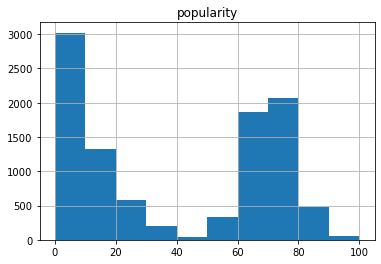

In [291]:
df.hist(column='popularity');

Unfortunately, I have about 3,000 songs with a popularity score of zero. This is a huge chunk of our data. When and where do such values occur? Since `popularity` is an instantaneous metric, not cumulative over the track's lifetime, perhaps recent artists have higher scores. Do the zero values fall disproportionately in the early years?

### Popularity by year

In [292]:
years = sorted(df['year'].unique())
len(years)

45

Even though I explicitly searched the years 2012 through 2021, I received results from 45 different years. (This is due to the idiosyncratic nature of the search API described earlier -- every track retrieved from search "q=year:2012" was not necessarily released in 2012.) I'd like to explore the relationship between `year` and `popularity`. I will change the `year` column to integers for the sake of filtering, calculate the mean popularity for each year, and visualize.

In [293]:
df = df.astype({'year':'int'})
avg_pop_by_year = df[['year','popularity']].groupby(by='year').agg('mean')
avg_pop_by_year['size'] = df[['year','popularity']].groupby(by='year').size()
avg_pop_by_year.reset_index(inplace=True)

In [294]:
avg_pop_by_year['size'].describe()

count      45.000000
mean      222.222222
std       413.695040
min         1.000000
25%         2.000000
50%         5.000000
75%        20.000000
max      1232.000000
Name: size, dtype: float64

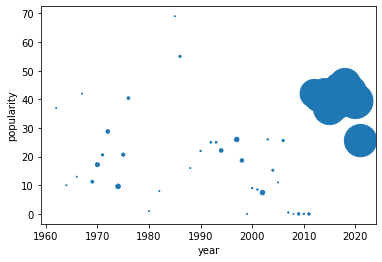

In [295]:
avg_pop_by_year.plot.scatter('year','popularity', s='size');

There is only a smattering of records prior to 2012, as expected. No clear relationship between `year` and `popularity` is visible yet. Let's visualize the same for just the past 10 years.

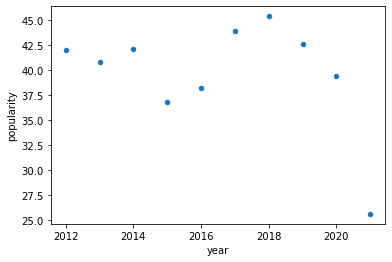

In [296]:
avg_pop_last_10 = avg_pop_by_year[avg_pop_by_year['year'] >= 2012]
avg_pop_last_10.plot.scatter('year','popularity');

From 2012 to 2020, there continues to be no obvious relationship between `year` and `popularity`, however the average `popularity` for 2021 is much lower. This makes some sense; much of the newest music (other than from established artists) would not have had much of a chance to establish popularity.

Still, these mean values are all greatly affected by the zero-popularity tracks. How are the zeroes distributed within each individual year? Since I know there are negligible numbers of tracks in the years before 2012, I will examine only the last 10 years.

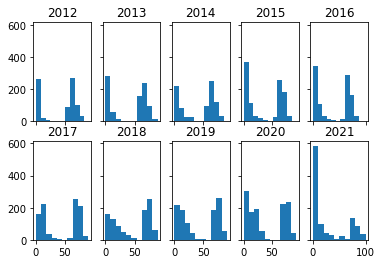

In [297]:
years = (yr for yr in sorted(df['year'].unique())[-10:])
fig, axs = plt.subplots(2, 5, sharey=True, sharex='col')
for r in range(2):
    for c in range(5):
        plotfilter = title = next(years)
        axs[r,c].hist(df[df['year']==plotfilter]['popularity'])
        axs[r,c].set_title(title)

I see bimodal distributions for `popularity` within each year. While the highest `popularity` values appear to occur in the most recent year, we see plenty of zero values in every year. In fact, zero is a notably frequent value each year, most drastically so in 2021. As noted previously, this last observation makes sense. While some of the most recent music will be the most popular, much brand-new music probably hasn't gotten much playtime yet. But we still don't know whether "zero" means "missing" vs. a valid, measured absence of popularity. Perhaps, in the case of this dataset, that's a distinction without a difference.

Crucially, however, each year contains a cluster of <i>low non-zero values</i>. Since a low non-zero `popularity` score could not possibly be a missing value, we can conclude that at least some of the zero scores are valid zeroes. Whether <i>any</i> of the zero scores reflect missing data is still unclear.

I will continue with the analysis and consider the possiblity that rather than modeling the specific value of `popularity`, I could instead treat this as a question of classification, predicting "high" vs. "low" popularity. "High" popularity could be defined as any score above 50, for example, based on the bimodal distributions visualized above.

### Verifying popularity uniqueness by track

I want to verify that `popularity` corresponds to individual tracks. If, on the other hand, all songs by a given `artist` or `album` share the same `popularity` score, then I have a problem.

In [184]:
def check_duplicate_popularities(feature):
    """Accepts feature name string. Prints a report of the number of unique values of that feature where:
    1) There is more than one instance of that value, and
    2) The `popularity` scores for all instances of that value are identical"""
    #create list of unique values of given feature
    feature_uniques = list(df[feature].unique())
    #initiate counter
    duplicate_popularities = 0
    for unique in feature_uniques:
        #count number of records corresponding to unique value
        unique_count = len(df[df[feature] == unique])
        #create set of `popularity` scores for unique value
        unique_popularities = set(df[df[feature] == unique]['popularity'].values) 
        if unique_count >1 and len(unique_popularities) == 1:
            duplicate_popularities += 1
    print("For feature '{}', there are {} total unique values in the dataset.".format(feature, len(feature_uniques)))
    print("When a particular unique value corresponds to more than one track, those records share `popularity` scores", duplicate_popularities, "times.")

In [185]:
check_duplicate_popularities('artist')

For feature 'artist', there are 3097 total unique values in the dataset.
When a particular unique value corresponds to more than one track, those records share `popularity` scores 157 times.


Of the 3,133 unique artists in my DataFrame, only 157 of them have multiple tracks which all share `popularity` scores. These 157 cases are most likely coincidences. Perhaps there are just two tracks corresponding to a particular artist, and both tracks have the same `popularity`. (Given what we saw above, my guess is that the shared `popularity` scores in such cases is zero). At any rate, the fact that <i>all</i> of the `artist` values don't share common `popularity` scores is a good sign. Let's perform the same check for `album` next:

In [186]:
check_duplicate_popularities('album')

For feature 'album', there are 4228 total unique values in the dataset.
When a particular unique value corresponds to more than one track, those records share `popularity` scores 181 times.


A similarly low result, relative to the total unique values. So, we can conclude that `popularity` is not applied identically to all tracks corresponding to either a given `artist` or `album`. It is apparent that, as hoped, Spotify assigns `popularity` to each track separately.

### Time signature, key, and mode

Next, I need to address the features `time_signature`, `key`, and `mode`. Pandas read each into the DataFrame as type `float64` automatically, due to having numeric values. However, they are better represented by other data types, as I will now demonstrate. I will employ some background knowledge in music theory, supplemented by the <a href="https://count.co/n/OqA2ey7ZvI5">data dictionary</a>.

"Time signature" relates to the rhythmic structure of a song. It's comprised of two numbers: The number of beats in each measure (i.e., each discrete rhythmic chunk of the song), and the type of note counted as one beat. Western music typically has a time signature of 4/4 (pronounced "four-four"), meaning that each measure contains four quarter-notes. Theoretically, there is an infinite number possible time signatures, and different regions of the world do have slightly different time signature conventions. In practice, however, artists stick to the same relatively small set of options. Other than 4/4, common time signatures include 6/8 and 3/4. Jazz is the genre most likely to use unconventional time signatures, like 5/4 or 7/8. In this dataset, `time_signature` contains only the first part of a typical time signature: The number of beats per measure. Songs written in 4/4 would appear here as `time_signature` = 4. Even though it's represented numerically, it's best understood as a category due to the low number of practical values.

A song's `key` is the musical note that represents the home, resolution, or "tonic" of the piece. It's the note or chord that your ear recognizes as the basis of the song, around which the melody and other chords revolve. There's a sense of satisfaction when the melody returns to the tonic at the end of a musical phrase. Likewise, composers create tension by leading the melody elsewhere. Our dataset contains `key` information as integers, where 0 = C, 1 = C#, etc. This is called <a href="https://en.wikipedia.org/wiki/Pitch_class"> pitch class notation</a>. Once again, though represented numerically, `key` should be considered a category.

In addition to the "tonic" chord, a song's key is also described as being "major" or "minor." Simply put, this relates to whether the listener perceives it as a happy or sad song. For example, "Happy Birthday" is written in a major key; Johnny Cash's "Hurt" is minor. This is formally called the "modality" of the song. In our dataset, modality appears as `mode`, where 0 = minor and 1 = major. This neatly fits a Boolean representation, where `major` is True or False.

In [298]:
df = df.astype({'time_signature':'category', 'key':'category', 'mode':'bool'})
df.rename(columns={'mode':'major'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   track_id           10000 non-null  object  
 1   name               10000 non-null  object  
 2   artist             10000 non-null  object  
 3   album              10000 non-null  object  
 4   year               10000 non-null  int64   
 5   popularity         10000 non-null  int64   
 6   duration_ms        10000 non-null  int64   
 7   explicit           10000 non-null  bool    
 8   track_number       10000 non-null  int64   
 9   disc_number        10000 non-null  int64   
 10  available_markets  10000 non-null  object  
 11  album_type         10000 non-null  object  
 12  danceability       9997 non-null   float64 
 13  energy             9997 non-null   float64 
 14  loudness           9997 non-null   float64 
 15  speechiness        9997 non-null   float64 
 16  acous

### Available markets

Now, I will return to my question about the `available_markets` field. Each value appears to be a list of country codes. The lists are quite long, however it would appear that many tracks share a common list of countries. I suspect that even though there are many individual countries within a given list, there is a small number of unique lists in that column.

In [299]:
len(df.available_markets.unique())

446

Ah. There is decidedly <i>not</i> a small number of unique values. It doesn't make sense to treat this as a categorical feature. Perhaps, though, it could be useful for my model to consider the number of countries in which a song is available. I will calculate and append that column for later.

In [300]:
df['available_markets_total'] = pd.Series([len(x) for x in df.available_markets])

In [301]:
df[['available_markets', 'available_markets_total']].head()

,available_markets,available_markets_total
0,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1020
1,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1068
2,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1068
3,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1068
4,"['CA', 'US']",12


Problem. Row index 4 clearly shows just two countries, yet the returned length is 12. I overlooked the fact that `available_markets` is being treated as a column of strings, where string represents a list.

In [302]:
df['available_markets'] = [x.strip("']['") for x in df.available_markets]
df['available_markets'] = [x.replace("'","") for x in df.available_markets]
df['available_markets'] = [x.split(", ") for x in df.available_markets]
df['available_markets_total'] = pd.Series([len(x) for x in df.available_markets])
df[['available_markets', 'available_markets_total']].head()

,available_markets,available_markets_total
0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",170
1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",178
2,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",178
3,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",178
4,"[CA, US]",2


Much better. I will keep both columns, though. Later on, it might be useful to check the `available_markets` column for specific countries.

## 4. Data Cleaning <a class="anchor" id="data-cleaning"></a>

Looking at the df.info() earlier, I see that there are only three tracks containing NaN values for my audio features. Because of the way I pulled in the data from the API and stored it in my DataFrame, I know that for any track where any given audio features is NaN, <i>all</i> of the audio features for that track are NaN (except for `major`, the feature I converted to Boolean, where NaN values were converted to False). Luckily, that's true of just three tracks in my dataset. I can isolate my three problem tracks by filtering for NaN values in any one of my audio features:

In [303]:
df[df['danceability'].isnull().values]

,track_id,name,artist,album,year,popularity,duration_ms,explicit,track_number,disc_number,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,major,key,available_markets_total
4614,04boE4u1AupbrGlI62WvoO,White Noise 3 Hour Long,Erik Eriksson,White Noise 3 Hour Long,2016,66,10828190,False,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,177
7613,5iNrI16WkfbzuGqaxZCJBV,BULLET TRAIN ARENA TOUR 2019-2020「Revolucion v...,Bullet Train,BULLET TRAIN ARENA TOUR 2019-2020「Revolucion v...,2020,5,9300970,False,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,178
9846,0rWrhQIdbzIb24obQil8Wi,Relaxing Ambience for 2021,Restaurante Jazz Clásicos,Magnificent Backdrop for New Years Resolutions,2021,0,371,False,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,178


In [307]:
df = df[~df['danceability'].isnull().values]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   track_id                 9997 non-null   object  
 1   name                     9997 non-null   object  
 2   artist                   9997 non-null   object  
 3   album                    9997 non-null   object  
 4   year                     9997 non-null   int64   
 5   popularity               9997 non-null   int64   
 6   duration_ms              9997 non-null   int64   
 7   explicit                 9997 non-null   bool    
 8   track_number             9997 non-null   int64   
 9   disc_number              9997 non-null   int64   
 10  available_markets        9997 non-null   object  
 11  album_type               9997 non-null   object  
 12  danceability             9997 non-null   float64 
 13  energy                   9997 non-null   float64 
 14  loudness

It is no great loss to drop these three tracks from my original list of ten thousand.

### Artist collaborations

As mentioned earlier, several track names contain the string pattern "feat." to indicate a collaboration with one or more guest artists (i.e., "artist features", not to be confused with our DataFrame features, nor our audio features). Such collaborations are particularly common in pop music. I'd like to create a new Boolean column indicating the presence of a collaboration, to potentially include in my model.

In [308]:
df[df.name.str.contains('feat.')].head()

,track_id,name,artist,album,year,popularity,duration_ms,explicit,track_number,disc_number,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,major,key,available_markets_total,collab
24,3bidbhpOYeV4knp8AIu8Xn,Can't Hold Us - feat. Ray Dalton,Macklemore & Ryan Lewis,The Heist,2012,84,258342,False,2,1,...,0.0291,0.000000,0.0862,0.847,146.078,4.0,True,2.0,175,True
44,7a86XRg84qjasly9f6bPSD,We Are Young (feat. Janelle Monáe),fun.,Some Nights,2012,74,250626,False,3,1,...,0.0200,0.000077,0.0849,0.735,184.086,4.0,True,10.0,31,True
52,3cHyrEgdyYRjgJKSOiOtcS,Timber (feat. Ke$ha),Pitbull,Global Warming: Meltdown (Deluxe Version),2012,81,204160,False,13,1,...,0.0295,0.000000,0.1390,0.788,129.992,4.0,True,11.0,164,True
61,2WBL8JyDgUoDkHMz5VnP3r,Kyoto (feat. Sirah),Skrillex,Big Beat Yearbook: 2012,2012,26,200786,True,4,1,...,0.0012,0.000596,0.4830,0.219,174.974,4.0,False,4.0,1,True
68,1mKXFLRA179hdOWQBwUk9e,Just Give Me a Reason (feat. Nate Ruess),P!nk,The Truth About Love,2012,82,242733,False,4,1,...,0.3460,0.000302,0.1320,0.441,95.002,4.0,True,2.0,178,True


In [309]:
df.name.str.contains('feat.').sum()

648

In [310]:
df['collab'] = df.name.str.contains('feat.')
df.collab.sum()

648

I have created the `collab` column to indicate whether the track name contains the string pattern "feat." and verified the column validity by both visually inspecting the filtered data and checking the length of the Boolean series.

### Ensuring a unique identifier

I pulled `track_id` to use as a unique identifier. Let's verify that.

In [311]:
df.track_id.is_unique

False

Not good. That column should have 9,997 unique values. How many does it actually have?

In [312]:
unique_ids = len(df.track_id.unique())
unique_ids

9852

In [313]:
df_all_dupes = df[df.duplicated(subset='track_id', keep=False)].sort_values('track_id')
df_all_dupes

,track_id,name,artist,album,year,popularity,duration_ms,explicit,track_number,disc_number,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,major,key,available_markets_total,collab
19,00ohIpPn9LkKpeIqhfIU9V,K-Love Fan Awards: Songs of the Year (2014 Mas...,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,2014,27,213164,False,1,1,...,0.829000,0.00000,0.376,0.2290,119.515,4.0,True,11.0,178,False
7013,00ohIpPn9LkKpeIqhfIU9V,K-Love Fan Awards: Songs of the Year (2014 Mas...,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,2014,27,213164,False,1,1,...,0.829000,0.00000,0.376,0.2290,119.515,4.0,True,11.0,178,False
2001,00ohIpPn9LkKpeIqhfIU9V,K-Love Fan Awards: Songs of the Year (2014 Mas...,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,2014,27,213164,False,1,1,...,0.829000,0.00000,0.376,0.2290,119.515,4.0,True,11.0,178,False
4015,00ohIpPn9LkKpeIqhfIU9V,K-Love Fan Awards: Songs of the Year (2014 Mas...,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,2014,27,213164,False,1,1,...,0.829000,0.00000,0.376,0.2290,119.515,4.0,True,11.0,178,False
6013,00ohIpPn9LkKpeIqhfIU9V,K-Love Fan Awards: Songs of the Year (2014 Mas...,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,2014,27,213164,False,1,1,...,0.829000,0.00000,0.376,0.2290,119.515,4.0,True,11.0,178,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,7z2DoAKkXgPDDPmipdrrd8,Year of the Wooden Horse,Jonny Nash,Framed Space: Selected Works 2014-2017,2019,8,293694,False,3,1,...,0.918000,0.85200,0.106,0.0362,130.776,5.0,True,10.0,177,False
7025,7zUogmz7vHIVvsOSuSynKL,September,"Earth, Wind & Fire",New Year's Eve - NYE 2018/2019,2018,37,215973,False,30,1,...,0.144000,0.00003,0.170,0.9810,125.570,4.0,True,9.0,178,False
6077,7zUogmz7vHIVvsOSuSynKL,September,"Earth, Wind & Fire",New Year's Eve - NYE 2018/2019,2018,37,215973,False,30,1,...,0.144000,0.00003,0.170,0.9810,125.570,4.0,True,9.0,178,False
6745,7zZhjyoFrpREKwrECYcg20,The Good Years,Cheerleader,Demos 2016-2018,2021,3,282146,False,13,1,...,0.000003,0.74000,0.172,0.6620,83.983,4.0,True,5.0,178,False


When two rows share a `track_id`, are they otherwise identical?

In [314]:
df_all_dupes.iloc[0] == df_all_dupes.iloc[1]

track_id                   True
name                       True
artist                     True
album                      True
year                       True
popularity                 True
duration_ms                True
explicit                   True
track_number               True
disc_number                True
available_markets          True
album_type                 True
danceability               True
energy                     True
loudness                   True
speechiness                True
acousticness               True
instrumentalness           True
liveness                   True
valence                    True
tempo                      True
time_signature             True
major                      True
key                        True
available_markets_total    True
collab                     True
dtype: bool

Thus, it is safe to delete rows from the main DataFrame by filtering out duplicates in the `track_id` column.

In [315]:
df = df[~df.duplicated(subset='track_id')]

In [316]:
df.track_id.is_unique

True

Now I have a unique identifier column, and no duplicate rows in my dataset. It occurs to me that those 144 duplicates were included in my earlier exploration of `year` and `popularity`. I'll take a closer look at that, and plenty of other important questions, in the exploratory data analysis notebook. I will now save the cleaned data.

In [317]:
df.to_csv('./data/cleaned.csv')